# Functions guide for homormophic encryption simulation

In these notebook we show how the functions of our library work.

## Table of Contents

- [Packages](#-1)
- [0 - Function count_gates](#0)
- [1 - Function compile_clifford_t_circuit](#1)
- [2 - Function run_circuit](#2)
- [3 - Function create_homomorphic_circuit](#3)
- [4 - Function create_simplified_homomorphic_circuit](#4)
- [5 - Function last_register_counts](#5)
- [6 - Function decrypt_counts](#6)
- [7 - Function counts_to_probability_distribution](#7)
- [8 - References](#8)

<a name='-1'></a>
## Packages

In [1]:
import numpy as np
import re
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
import cqc_qhe as cqc

The code has been tested on qiskit 1.1.0, and qiskit-aer 0.14.1.

In [2]:
import qiskit
qiskit.__version__

'1.1.0'

In [3]:
import qiskit_aer
qiskit_aer.__version__

'0.16.1'

<a name='0'></a>
## 0 - Function ``count_gates``

Args:
- circuit: Quantum circuit.
- gates: List of gates or a single gate as string.
- as_list: If True, a list with an individual counter for each gate is provided.

Returns:
- counter: Total number of gates or a list with the number of each gate.

This is a helper function that counts the number of a given set of gates.

In [4]:
def count_gates(circuit,gates,as_list=False):
    if type(gates) == str: gates = [gates]
    
    data = circuit.data
    counter = [0]*len(gates)
    for d in data:
        name = d[0].name
        for index, gate in enumerate(gates):
            if name == gates[index]:
                counter[index] += 1
    
    if not as_list: counter = sum(counter)
    
    return counter

In [5]:
circuit = QuantumCircuit(2)
circuit.x([0,1])
circuit.z(1)
circuit.cx(0,1)

count_gates(circuit,gates=['x','z','cx'])

4

<a name='1'></a>
## 1 - Function ``compile_clifford_t_circuit``

Args:
- circuit: Quantum circuit to compile.
- error_circuit: Error of approximating the circuit.
- ancilla_top: If True, the ancilla register is at the top of the circuit.
- error_gate: Error of each individual Rz and phase gate.
- compile_rz: If False, Rz and phase gates are not compiled.

Returns:
- compiled_circuit: Compiled circuit into Clifford+T gates.

This functions takes a quantum circuit and compile it into Clifford+T gates.

We will compile the following circuit.

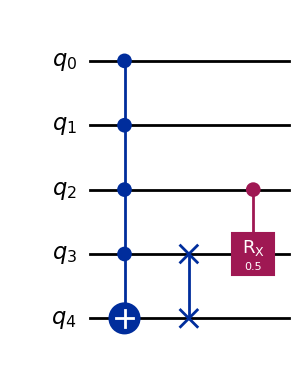

In [6]:
circuit = QuantumCircuit(5)
circuit.mcx([0,1,2,3],[4])
circuit.swap(3,4)
circuit.crx(0.5,2,3)

circuit.draw('mpl')

First, we need functions that apply certain complex gates decomposed in Clifford+$T$ gates, and $Rz$ (or phase) gates.

In [7]:
def toffoli(circuit,qubits):
    """Apply a toffoli gate with Clifford+T gates.
    Args:
        circuit: Quantum circuit.
        qubits: Set of qubits where the gate is applied.
    """
    
    circuit.h(qubits[2])
    circuit.cx(qubits[1],qubits[2])
    circuit.tdg(qubits[2])
    circuit.cx(qubits[0],qubits[2])
    circuit.t(qubits[2])
    circuit.cx(qubits[1],qubits[2])
    circuit.tdg(qubits[2])
    circuit.cx(qubits[0],qubits[2])
    circuit.t(qubits[1])
    circuit.t(qubits[2])
    circuit.cx(qubits[0],qubits[1])
    circuit.h(qubits[2])
    circuit.t(qubits[0])
    circuit.tdg(qubits[1])
    circuit.cx(qubits[0],qubits[1])

def control_h(circuit,qubits):
    """Apply a control-H gate with Clifford+T gates.
    Args:
        circuit: Quantum circuit.
        qubits: Set of qubits where the gate is applied.
    """
    
    # H = S @ H @ T @ H @ Sdg @ H @ X @ H @ S @ H @ Tdg @ H @ Sdg
    circuit.sdg(qubits[1])
    circuit.h(qubits[1])
    circuit.tdg(qubits[1])
    circuit.h(qubits[1])
    circuit.s(qubits[1])
    circuit.h(qubits[1])
    circuit.cx(qubits[0],qubits[1])
    circuit.h(qubits[1])
    circuit.sdg(qubits[1])
    circuit.h(qubits[1])
    circuit.t(qubits[1])
    circuit.h(qubits[1])
    circuit.s(qubits[1])

def control_rx(theta,circuit,qubits):
    """Apply a control-Rx gate with Clifford+T gates.
    Args:
        circuit: Quantum circuit.
        qubits: Set of qubits where the gate is applied.
    """
    
    circuit.h(qubits[1])
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(-theta/2,qubits[1])
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(theta/2,qubits[1])
    circuit.h(qubits[1])

def control_ry(theta,circuit,qubits):
    """Apply a control-Ry gate with Clifford+T gates.
    Args:
        circuit: Quantum circuit.
        qubits: Set of qubits where the gate is applied.
    """
    
    circuit.sdg(qubits[1])
    circuit.h(qubits[1])
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(-theta/2,qubits[1])
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(theta/2,qubits[1])
    circuit.h(qubits[1])
    circuit.s(qubits[1])

def control_rz(theta,circuit,qubits):
    """Apply a control-Rz gate with Clifford+T gates.
    Args:
        circuit: Quantum circuit.
        qubits: Set of qubits where the gate is applied.
    """
    
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(-theta/2,qubits[1])
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(theta/2,qubits[1])

def control_p(theta,circuit,qubits):
    """Apply a control-P gate with Clifford+T gates.
    Args:
        circuit: Quantum circuit.
        qubits: Set of qubits where the gate is applied.
    """
    
    circuit.p(theta/2,qubits[0])
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(-theta/2,qubits[1])
    circuit.cx(qubits[0],qubits[1])
    circuit.rz(theta/2,qubits[1])

We obtain the data of the circuit.

In [8]:
data = circuit.data

We calculate the number of ancilla qubits that we need. For that, we read the multicontrolled-X gates, and obtain the maximum number of control qubits.

In [9]:
# Calculate the number of ancilla qubits necessary.
max_dots = 0
for d in data:
    name = d[0].name
    if name == 'mcx' or name == 'mcx_gray':
        dots = d[0].num_qubits-1
        if dots > max_dots:
            max_dots = dots
n_ancilla = max_dots-2
if n_ancilla < 0: n_ancilla = 0

We create a quantum register for the ancillas.

In [10]:
# Create a quantum register with the ancillas.
ancilla_reg = QuantumRegister(n_ancilla,'anc')

We instantiate the compiled circuit, and append the ancilla register and the quantum and classical registers of the original circuit.

The ancilla register is appended at the bottom by default.

In [11]:
ancilla_top = False

In [12]:
# Obtain the quantum and classical registers of the original circuit.
quantum_registers = []
for index in range(len(circuit.qubits)):
    r = circuit.find_bit(circuit.qubits[index]).registers[0][0]
    if r not in quantum_registers:
        quantum_registers.append(r)
classical_registers = []
for index in range(len(circuit.clbits)):
    r = circuit.find_bit(circuit.clbits[index]).registers[0][0]
    if r not in classical_registers:
        classical_registers.append(r)

# Instantiate the compiled circuit.
compiled_circuit = QuantumCircuit()
if ancilla_top: compiled_circuit.add_register(ancilla_reg)
for index in range(len(quantum_registers)):
    compiled_circuit.add_register(quantum_registers[index])
if not ancilla_top: compiled_circuit.add_register(ancilla_reg)
for index in range(len(classical_registers)):
    compiled_circuit.add_register(classical_registers[index])

We read the instructions of the circuit from the data, and copy the Clifford+T gates. If the instructions corresponds to a controlled gate, the decompositions shown in [[1]](https://iopscience.iop.org/article/10.1088/2632-072X/add3aa) are performed. For a swap gate, we decompose it in three cnot gates.

In [13]:
# Copy the Clifford+T gates and compile the others.
for d in data:
    name = d[0].name
    qubits = d[1]
    clbits = d[2]

    if name == 'barrier':
        compiled_circuit.barrier(qubits)
    elif name == 'x':
        compiled_circuit.x(qubits)
    elif name == 'z':
        compiled_circuit.z(qubits)
    elif name == 'h':
        compiled_circuit.h(qubits)
    elif name == 's':
        compiled_circuit.s(qubits)
    elif name == 'sdg':
        compiled_circuit.sdg(qubits)
    elif name == 't':
        compiled_circuit.t(qubits)
    elif name == 'tdg':
        compiled_circuit.tdg(qubits)
    elif name == 'cx':
        compiled_circuit.cx(qubits[0],qubits[1])

    elif name == 'y':
        compiled_circuit.x(qubits)
        compiled_circuit.z(qubits)
    elif name == 'cy':
        compiled_circuit.sdg(qubits[1])
        compiled_circuit.h(qubits[1])
        compiled_circuit.cx(qubits[0],qubits[1])
        compiled_circuit.h(qubits[1])
        compiled_circuit.s(qubits[1])
    elif name == 'cz':
        compiled_circuit.h(qubits[1])
        compiled_circuit.cx(qubits[0],qubits[1])
        compiled_circuit.h(qubits[1])
        
    elif name == 'ccx':
        toffoli(compiled_circuit,(qubits[0],qubits[1],qubits[2]))
    elif name == 'rx':
        theta = d[0].params[0]
        compiled_circuit.h(qubits)
        compiled_circuit.rz(theta,qubits)
        compiled_circuit.h(qubits)
    elif name == 'ry':
        theta = d[0].params[0]
        compiled_circuit.sdg(qubits)
        compiled_circuit.h(qubits)
        compiled_circuit.rz(theta,qubits)
        compiled_circuit.h(qubits)
        compiled_circuit.s(qubits)
    elif name == 'rz':
        theta = d[0].params[0]
        compiled_circuit.rz(theta,qubits)
    elif name == 'p':
        theta = d[0].params[0]
        compiled_circuit.p(theta,qubits)
    elif name == 'ch':
        control_h(compiled_circuit,qubits)
    elif name == 'crx':
        theta = d[0].params[0]
        control_rx(theta,compiled_circuit,qubits)
    elif name == 'cry':
        theta = d[0].params[0]
        control_ry(theta,compiled_circuit,qubits)
    elif name == 'crz':
        theta = d[0].params[0]
        control_rz(theta,compiled_circuit,qubits)
    elif name == 'cp':
        theta = d[0].params[0]
        control_p(theta,compiled_circuit,qubits)
    
    elif name == 'u':
        theta, phi, lam = d[0].params
        compiled_circuit.rz(lam,qubits)
        compiled_circuit.h(qubits)
        compiled_circuit.s(qubits)
        compiled_circuit.h(qubits)
        compiled_circuit.rz(theta,qubits)
        compiled_circuit.h(qubits)
        compiled_circuit.sdg(qubits)
        compiled_circuit.h(qubits)
        compiled_circuit.rz(phi,qubits)

    elif (name == 'mcx' or name == 'mcx_gray'):
        number_anc = len(qubits)-1 -2
        toffoli(compiled_circuit,(qubits[0],qubits[1],ancilla_reg[0]))
        for index in range(1,number_anc):
            toffoli(compiled_circuit,(qubits[1+index],ancilla_reg[index-1],ancilla_reg[index]))
        toffoli(compiled_circuit,(qubits[-2],ancilla_reg[number_anc-1],qubits[-1]))
        for index in range(number_anc-1,1-1,-1):
            toffoli(compiled_circuit,(qubits[1+index],ancilla_reg[index-1],ancilla_reg[index]))
        toffoli(compiled_circuit,(qubits[0],qubits[1],ancilla_reg[0]))

    elif name == 'swap':
        compiled_circuit.cx(qubits[0],qubits[1])
        compiled_circuit.cx(qubits[1],qubits[0])
        compiled_circuit.cx(qubits[0],qubits[1])

    elif name == 'measure':
        compiled_circuit.measure(qubits,clbits)
    elif name == 'reset':
        compiled_circuit.reset(qubits)

    else:
        raise Exception(f'Wrong gate in the circuit: {name}')

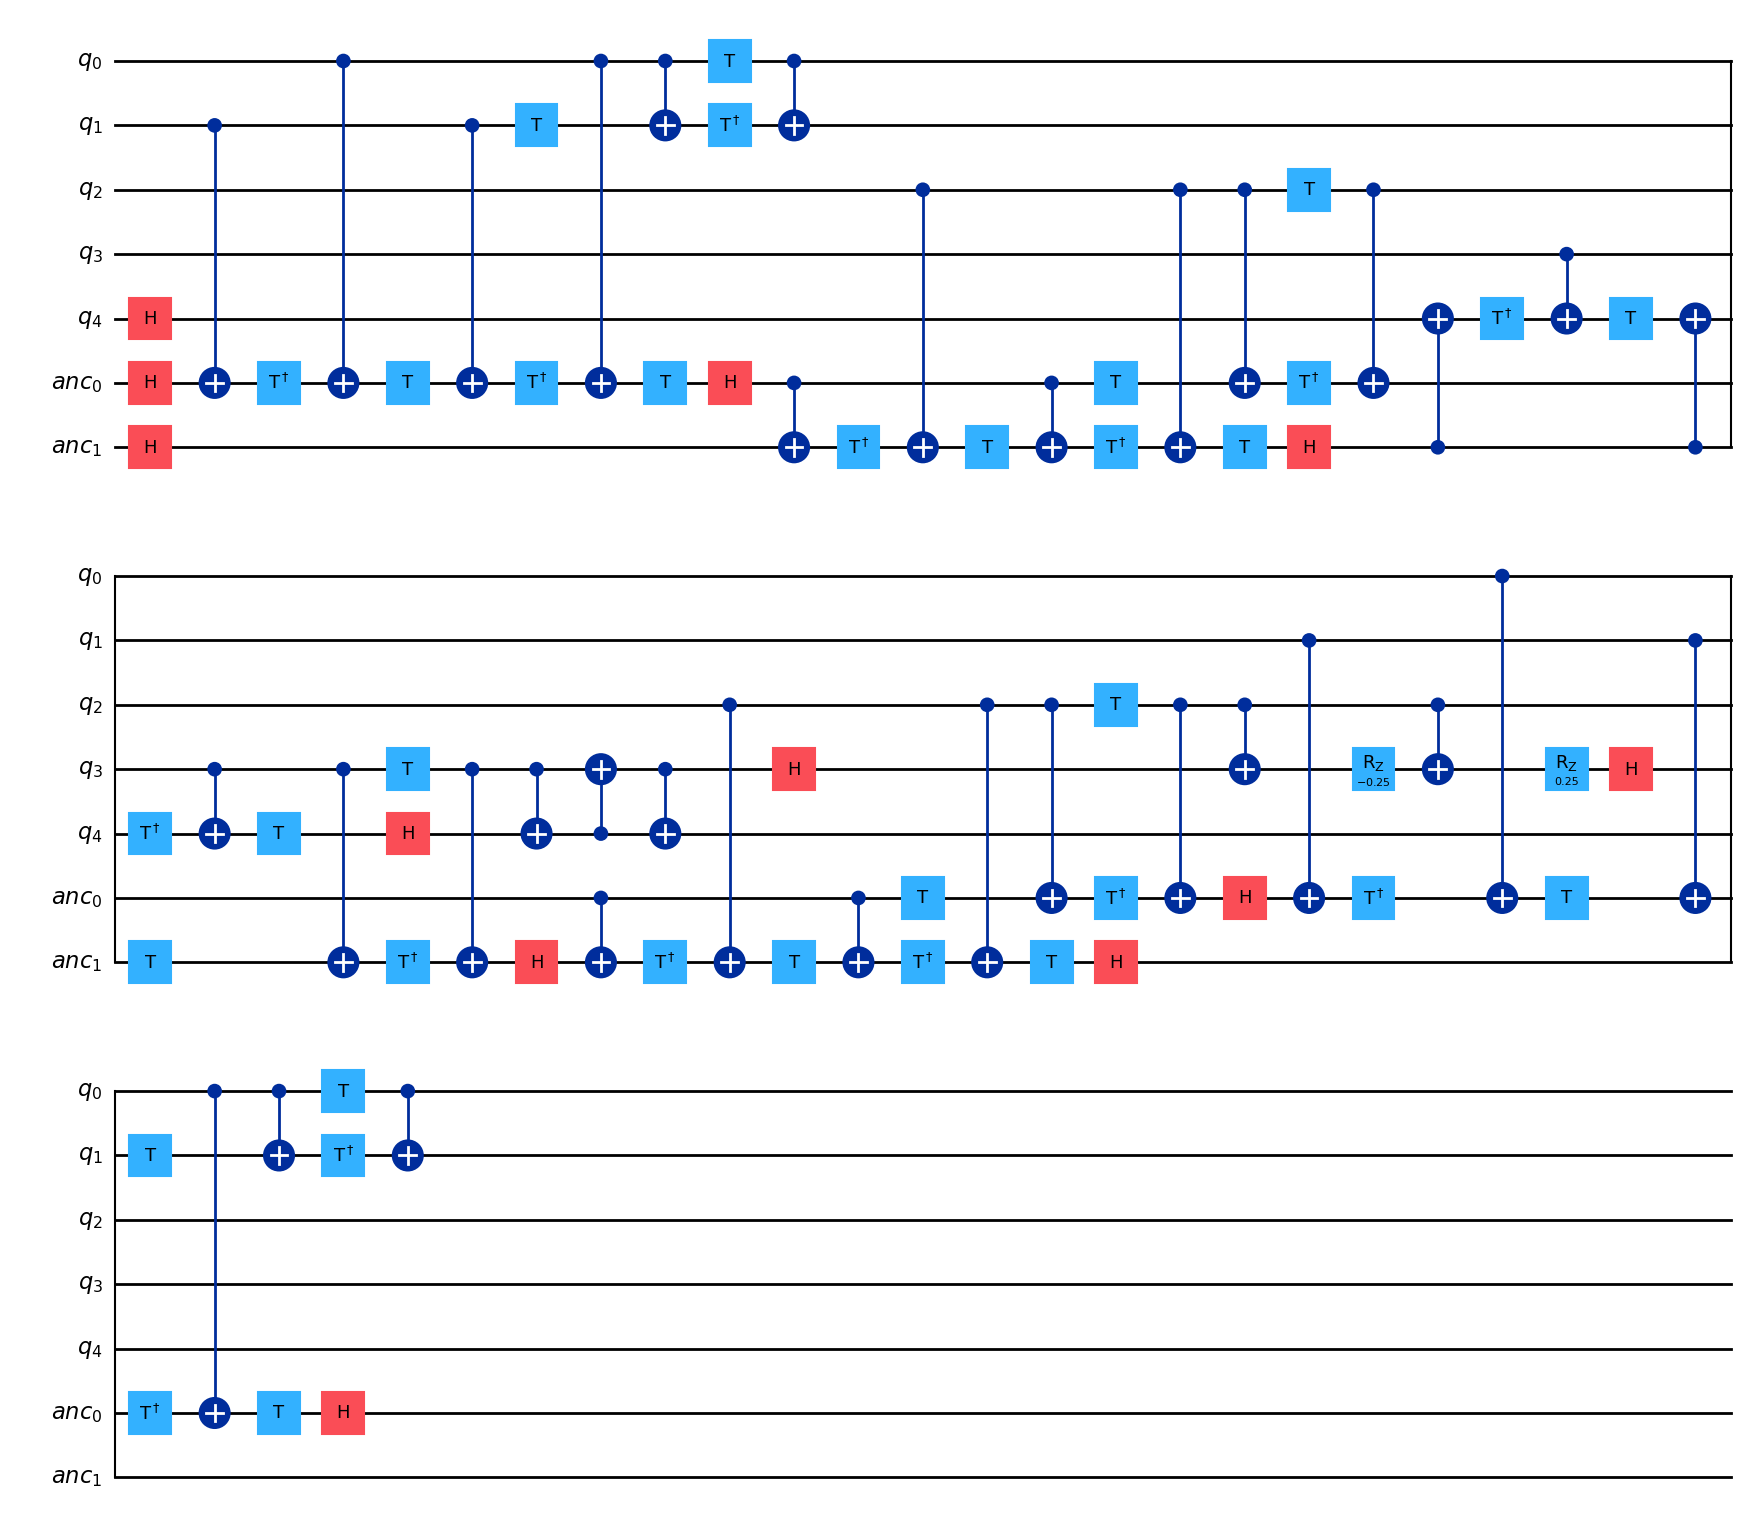

In [14]:
compiled_circuit.draw('mpl')

So far, $Rz$ (and phase) gates are not compiled. If gridsynth [[2]](https://dl.acm.org/doi/abs/10.5555/3179330.3179331) is installed, these gates are decomposed.

In [15]:
cqc.check_gridsynth()
#cqc.install_gridsynth()

True

We need a helper function to compile each $Rz$ gate.

In [16]:
def compile_rz_gate(theta,error=None,pauli=True):
    """Compile an Rz or phase gate in Clifford+T gates.
    Args:
        theta: Angle of the gate.
        error: Error of the decomposition. Default: 1e-10.
        pauli: If True, double S gates are turned into Z gates.
    Returns:
        chain: String with the sequence of Clifford+T gates.
    Raises:
        Exception: If gridsynth produces an empty string.
    """
    
    while theta < 0: theta += 2*np.pi
    while theta > 2*np.pi: theta -= 2*np.pi
    
    chain = cqc.gridsynth(theta,error)
    
    if chain == '':
        raise Exception('gridsynth produced an empty string.')
    
    if pauli:
        chain = re.sub(r"SSS", "SZ", chain)
        chain = re.sub(r"SS", "Z", chain)
    
    return chain

We set the error of the circuit, and calculate the error per gate. By default the error per gate is $\varepsilon = 10^{-10}$.

In [17]:
error_circuit = 2e-10

number_rz = count_gates(compiled_circuit,['rz','p'])

if number_rz > 0:

    # Calculate the error per gate.
    if error_circuit is not None: error_gate = error_circuit / number_rz

We reinstantiate an empty circuit.

In [18]:
circuit = compiled_circuit.copy()

# Obtain the quantum and classical registers of the original circuit.
quantum_registers = []
for index in range(len(circuit.qubits)):
    r = circuit.find_bit(circuit.qubits[index]).registers[0][0]
    if r not in quantum_registers:
        quantum_registers.append(r)
classical_registers = []
for index in range(len(circuit.clbits)):
    r = circuit.find_bit(circuit.clbits[index]).registers[0][0]
    if r not in classical_registers:
        classical_registers.append(r)

# Instantiate the compiled circuit.
compiled_circuit = QuantumCircuit()
for index in range(len(quantum_registers)):
    compiled_circuit.add_register(quantum_registers[index])
for index in range(len(classical_registers)):
    compiled_circuit.add_register(classical_registers[index])

We compile the rotation gates.

In [19]:
if cqc.check_gridsynth():

    # Compile the rotation gates and copy the others.
    data = circuit.data
    for d in data:
        name = d[0].name
        qubits = d[1]

        if name == 'p' or name == 'rz':
            theta = d[0].params[0]

            output = compile_rz_gate(theta,error_gate)

            # The gates are read in the reverse order.
            for gate in output[::-1]:
                if gate == 'S':
                    compiled_circuit.s(qubits)
                elif gate == 'T':
                    compiled_circuit.t(qubits)
                elif gate == 'H':
                    compiled_circuit.h(qubits)
                elif gate == 'X':
                    compiled_circuit.x(qubits)
                elif gate == 'Z':
                    compiled_circuit.z(qubits)
                elif gate == 'I':
                    pass
                else:
                    raise Exception(f'Wrong gate in the Rz decomposition: {gate}')

        else:
            compiled_circuit.data.append(d)

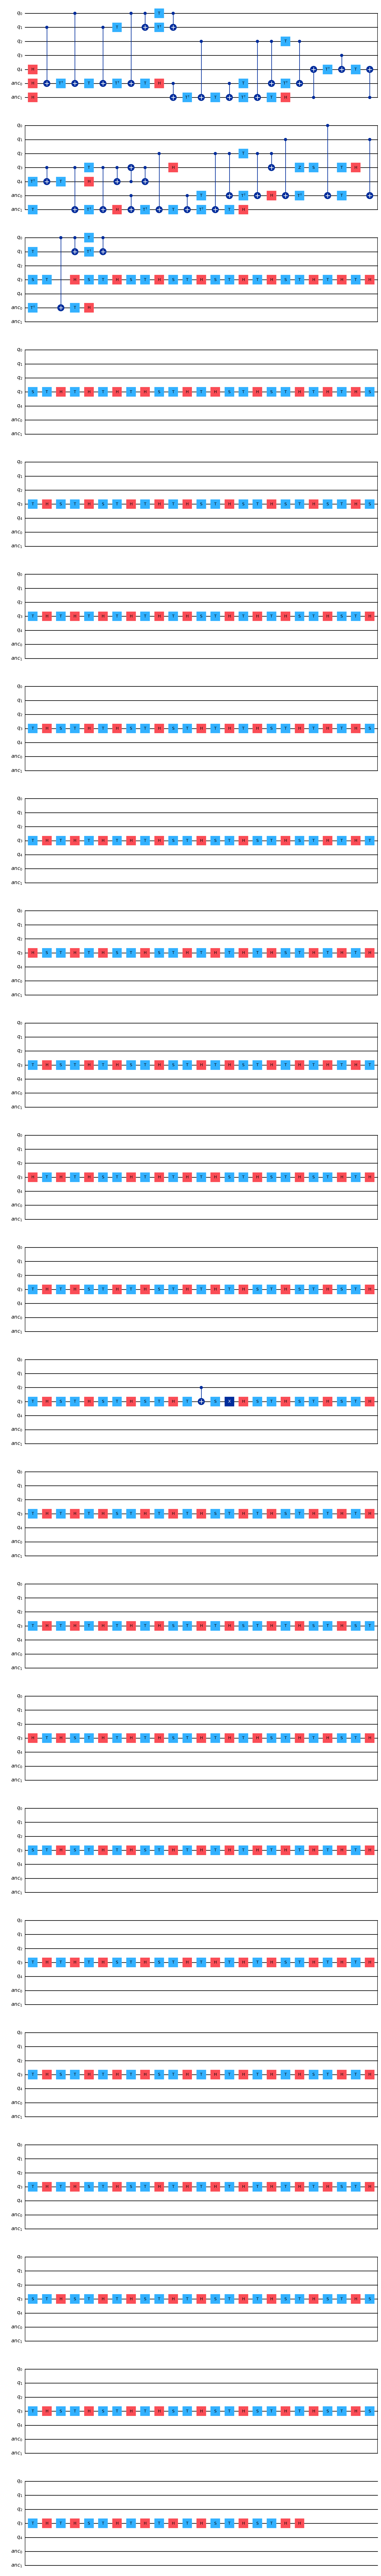

In [20]:
compiled_circuit.draw('mpl')

<a name='2'></a>
## 2 - Function ``run_circuit``

Args:
- circuit: Quantum circuit.
- shots: Number of shots.
- reverse: If True (default), the order of the bits is reversed.
    
Returns:
- counts: Dictionary with the counts.

Qiskit uses little-endian order for the bits, so that when measuring, the first bit in the result is the one at bottom. In [[1]](https://iopscience.iop.org/article/10.1088/2632-072X/add3aa) we use big-endian order, so that the uppermost bit is the first one. To correct the measurements, we use the following helper function.

In [21]:
def reverse_counts(counts):
    """Reverse the order of the bits.
    Args:
        counts: Dictionary with the counts of the simulation.
    Returns:
        reversed_counts: Dictionary with the counts after reversing the bits order.
    """
    
    reversed_counts = {}
    for key in counts:
        reversed_counts[key[::-1]] = counts[key]
    
    return reversed_counts

We instantiate the simulator from Aer and run the circuit. Finally, we reverse the order of the bits in the result.

In [22]:
circuit = QuantumCircuit(7)
circuit.x(range(3))
circuit.measure_all()

shots = 10

simulator = AerSimulator()
job = simulator.run(circuit, shots=shots)
counts = job.result().get_counts(0)
counts = reverse_counts(counts)

counts

{'1110000': 10}

<a name='3'></a>
## 3 - Function ``create_homomorphic_circuit``

Args:
- init_circuit: Initial circuit by the client.
- main_circuit: Main circuit by the server. It must be compiled into Clifford+T gates.
- measured_qubits: Qubits that are measured to obtain the final result.

Returns:
- homomorphic_circuit: Homomorphic circuit for the simulation.

We want to create the homomorphic circuit for the simulation, starting from the initial circuit of the client, and the main circuit of the server.

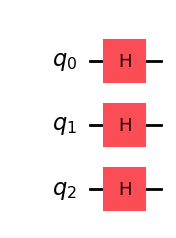

In [23]:
init_circuit = QuantumCircuit(3)
init_circuit.h(range(3))
init_circuit.draw('mpl')

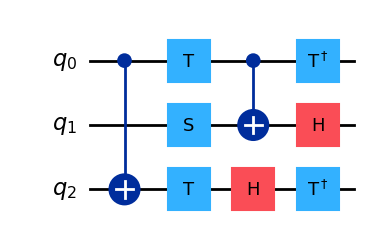

In [24]:
main_circuit = QuantumCircuit(3)
main_circuit.cx(0,2)
main_circuit.t(0)
main_circuit.t(2)
main_circuit.s(1)
main_circuit.cx(0,1)
main_circuit.h(1)
main_circuit.tdg(0)
main_circuit.h(2)
main_circuit.tdg(2)
main_circuit.draw('mpl')

Also, we create the following functions for applying classical gates to classical qubits, using quantum qubits as ancillas.

In [25]:
def classical_swap(circuit,bit_1,bit_2,ancilla_reg):
    """Apply a swap gate between two classical bits.
    Args:
        circuit: Quantum circuit.
        bit_1: Classical bit.
        bit_2: Classical bit.
        ancilla_reg: Quantum register used for the classical gates.
    """
    
    circuit.reset(ancilla_reg)
    circuit.x(ancilla_reg[0]).c_if(bit_1,1)
    circuit.x(ancilla_reg[1]).c_if(bit_2,1)
    circuit.swap(ancilla_reg[0],ancilla_reg[1])
    circuit.measure([ancilla_reg[0],ancilla_reg[1]],[bit_1,bit_2])

def classical_cnot(circuit,c_bit,t_bit,ancilla_reg):
    """Apply a classical cnot between two classical bits.
    Args:
        circuit: Quantum circuit.
        c_bit: Control bit.
        t_bit: Target bit.
        ancilla_reg: Quantum register used for the classical gates.
    """
    
    circuit.reset(ancilla_reg)
    circuit.x(ancilla_reg[0]).c_if(c_bit,1)
    circuit.x(ancilla_reg[1]).c_if(t_bit,1)
    circuit.cx(ancilla_reg[0],ancilla_reg[1])
    circuit.measure([ancilla_reg[0],ancilla_reg[1]],[c_bit,t_bit])

def classical_reset(circuit,bit,ancilla_reg):
    """Apply a classical reset to a classical bit.
    Args:
        circuit: Quantum circuit.
        bit: Classical bit.
        ancilla_reg: Quantum register used for the classical gates.
    """
    
    circuit.reset(ancilla_reg[0])
    circuit.measure(ancilla_reg[0],bit)

We need to provide the qubits that are going to be measured to obtain the final results.

In [26]:
measured_qubits = [0,1,2]

We obtain the quantum registers and qubits of the main circuit and instantiate the homomorphic circuit.

In [27]:
# Obtain the quantum registers of the main circuit.
registers = []
for index in range(len(main_circuit.qubits)):
    r = main_circuit.find_bit(main_circuit.qubits[index]).registers[0][0]
    if r not in registers:
        registers.append(r)

# Instantiate the homomorphic circuit with the quantum registers.    
homomorphic_circuit = QuantumCircuit()
for index in range(len(registers)):
    homomorphic_circuit.add_register(registers[index])

# Obtain the qubits of the main circuit.
main_qubits = main_circuit.qubits

We create classical registers for key updating, and also to store the initial key.

In [28]:
# Create classical registers for the keys.
x_init_key_reg = ClassicalRegister(len(main_qubits),'x_init_key')
z_init_key_reg = ClassicalRegister(len(main_qubits),'z_init_key')
homomorphic_circuit.add_register(x_init_key_reg)
homomorphic_circuit.add_register(z_init_key_reg)
x_key_reg = ClassicalRegister(len(main_qubits),'x_key')
z_key_reg = ClassicalRegister(len(main_qubits),'z_key')
homomorphic_circuit.add_register(x_key_reg)
homomorphic_circuit.add_register(z_key_reg)

We create quantum registers for the Bell pairs. A register per $T/T^\dagger$ gate. We also create the classical registers for the Bell measurement.

In [29]:
# Create quantum registers for the Bell pairs.
number_t_gates = count_gates(main_circuit,['t','tdg'])
bell_reg_list = [QuantumRegister(2,f'bell {_}') for _ in range(number_t_gates)]
for index in range(number_t_gates):
    homomorphic_circuit.add_register(bell_reg_list[index])

# Create classical registers for the Bell measurements.
ra_reg = ClassicalRegister(number_t_gates,'ra')
rb_reg = ClassicalRegister(number_t_gates,'rb')
homomorphic_circuit.add_register(ra_reg)
homomorphic_circuit.add_register(rb_reg)

For a semiclassical algorithm, we need to obtain the classical registers of the main circuit and append them to the homomorphic circuit.

In [30]:
# Obtain the classical registers of the original circuit (for semiclassical algorithms).
classical_registers = []
for index in range(len(main_circuit.clbits)):
    r = main_circuit.find_bit(main_circuit.clbits[index]).registers[0][0]
    if r not in classical_registers:
        classical_registers.append(r)

for index in range(len(classical_registers)):
    homomorphic_circuit.add_register(classical_registers[index])

Finally, we create a classical register for the measurements of the main qubits of the circuit.

In [31]:
# Create a classical register for measuring the main qubits.
measured_reg = ClassicalRegister(len(measured_qubits),'circ')
homomorphic_circuit.add_register(measured_reg)

The bitstrings of the results will contain several registers:
- Initial $X$ key
- Initial $Z$ key
- Final $X$ key
- Final $Z$ key
- Bell measurements $r_a$
- Bell measurements $r_b$
- Original classical registers
- Main qubits

The circuit has been instantiated. Now, we initialize the $X$ and $Z$ keys in their corresponding classical registers at random. For doing so, we apply $H$ gates to the main qubits, measure them and reset.

In [32]:
# Initialize the keys at random to the corresponding classical registers.
homomorphic_circuit.h(main_qubits)
homomorphic_circuit.measure(main_qubits,x_init_key_reg)
homomorphic_circuit.measure(main_qubits,x_key_reg)
homomorphic_circuit.reset(main_qubits)
homomorphic_circuit.barrier()
homomorphic_circuit.h(main_qubits)
homomorphic_circuit.measure(main_qubits,z_init_key_reg)
homomorphic_circuit.measure(main_qubits,z_key_reg)
homomorphic_circuit.reset(main_qubits)
homomorphic_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2), Qubit(QuantumRegister(2, 'bell 0'), 0), Qubit(QuantumRegister(2, 'bell 0'), 1), Qubit(QuantumRegister(2, 'bell 1'), 0), Qubit(QuantumRegister(2, 'bell 1'), 1), Qubit(QuantumRegister(2, 'bell 2'), 0), Qubit(QuantumRegister(2, 'bell 2'), 1), Qubit(QuantumRegister(2, 'bell 3'), 0), Qubit(QuantumRegister(2, 'bell 3'), 1)), clbits=())

We copy the instructions of the initial circuit of the client.

In [33]:
# Copy the initial circuit by the client.
for d in init_circuit.data:
    homomorphic_circuit.data.append(d)
homomorphic_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2), Qubit(QuantumRegister(2, 'bell 0'), 0), Qubit(QuantumRegister(2, 'bell 0'), 1), Qubit(QuantumRegister(2, 'bell 1'), 0), Qubit(QuantumRegister(2, 'bell 1'), 1), Qubit(QuantumRegister(2, 'bell 2'), 0), Qubit(QuantumRegister(2, 'bell 2'), 1), Qubit(QuantumRegister(2, 'bell 3'), 0), Qubit(QuantumRegister(2, 'bell 3'), 1)), clbits=())

The circuit is encrypted using $X$ and $Z$ gates controlled by the classical bits with the keys.

In [34]:
# Encrypt the circuit.
for index, q in enumerate(main_qubits):
    homomorphic_circuit.x(q).c_if(x_init_key_reg[index],1)
    homomorphic_circuit.z(q).c_if(z_init_key_reg[index],1)
homomorphic_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2), Qubit(QuantumRegister(2, 'bell 0'), 0), Qubit(QuantumRegister(2, 'bell 0'), 1), Qubit(QuantumRegister(2, 'bell 1'), 0), Qubit(QuantumRegister(2, 'bell 1'), 1), Qubit(QuantumRegister(2, 'bell 2'), 0), Qubit(QuantumRegister(2, 'bell 2'), 1), Qubit(QuantumRegister(2, 'bell 3'), 0), Qubit(QuantumRegister(2, 'bell 3'), 1)), clbits=())

Now the circuit is sent to the server. We apply the gates of the main circuit of the server. For the $T/T^\dagger$ gates we have to create a Bell pair in the corresponding quantum register and apply a swap gate, as explained in [[1]](https://iopscience.iop.org/article/10.1088/2632-072X/add3aa).

In [35]:
# Copy the main circuit by the server with the homomorphic quantum rules for T gates.
t_count = 0
for d in main_circuit.data:
    name = d[0].name
    # Obtain the bits and qubits of the gate.
    gate_qubits = d[1]
    gate_clbits = d[2]

    if name == 'x':
        homomorphic_circuit.x(gate_qubits)

    elif name == 'z':
        homomorphic_circuit.z(gate_qubits)

    elif name == 'h':
        homomorphic_circuit.h(gate_qubits)

    elif name == 's':
        homomorphic_circuit.s(gate_qubits)

    elif name == 'sdg':
        homomorphic_circuit.sdg(gate_qubits)

    elif name == 'cx':
        homomorphic_circuit.cx(gate_qubits[0],gate_qubits[1])

    elif name == 't':
        bell_reg = bell_reg_list[t_count]
        homomorphic_circuit.barrier()
        homomorphic_circuit.t(gate_qubits)
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.swap(gate_qubits[0],bell_reg[0])

        t_count += 1
        homomorphic_circuit.barrier()

    elif name == 'tdg':
        bell_reg = bell_reg_list[t_count]
        homomorphic_circuit.barrier()
        homomorphic_circuit.tdg(gate_qubits)
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.swap(gate_qubits[0],bell_reg[0])

        t_count += 1
        homomorphic_circuit.barrier()

    elif name == 'barrier':
        homomorphic_circuit.barrier(gate_qubits)

    elif name == 'measure':
        homomorphic_circuit.measure(gate_qubits,gate_clbits)

    elif name == 'reset':
        homomorphic_circuit.reset(gate_qubits)

    else:
        raise Exception(f'Wrong gate in the circuit: {name}')

The circuit is returned to the client. Then the main qubits are measured.

In [36]:
# Measure the qubits of the original circuit.
homomorphic_circuit.barrier()
homomorphic_circuit.measure(measured_qubits,measured_reg)

Finally, the client has to perform the classical and quantum gates needed to update the keys, as explained in [[1]](https://iopscience.iop.org/article/10.1088/2632-072X/add3aa).

For simulations purposes in qiskit, the classical gates are applied using an ancilla quantum register, as explained in the supplementary material of [[1]](https://iopscience.iop.org/article/10.1088/2632-072X/add3aa). In order to simplify the simulation, this register reutilizes the two first qubits of the circuits.

In [37]:
# Apply the homomorphic classical update rules in the circuit returned to the client.

# Create a quantum register for the classical gates.
# We use the first two qubits of the main circuit.
cl_gates_reg = main_qubits[0:2]

# Create a dictionary relating each qubit to its index.
qubits_dict = {q:index for index, q in enumerate(main_qubits)}

t_count = 0
for d in main_circuit.data:
    name = d[0].name
    # Obtain the bits and qubits of the gate.
    gate_qubits = d[1]
    gate_clbits = d[2]

    if name == 'x':
        pass

    elif name == 'z':
        pass

    elif name == 'h':
        classical_swap(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 's':
        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 'sdg':
        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 'cx':
        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],x_key_reg[qubits_dict[gate_qubits[1]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,z_key_reg[qubits_dict[gate_qubits[1]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 't':
        bell_reg = bell_reg_list[t_count]
        homomorphic_circuit.barrier()
        homomorphic_circuit.s(bell_reg[0]).c_if(x_key_reg[qubits_dict[gate_qubits[0]]],1)
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.measure(bell_reg,[rb_reg[t_count],ra_reg[t_count]])

        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,rb_reg[t_count],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,ra_reg[t_count],x_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

        t_count += 1
        homomorphic_circuit.barrier()

    elif name == 'tdg':
        bell_reg = bell_reg_list[t_count]
        homomorphic_circuit.barrier()
        homomorphic_circuit.s(bell_reg[0]).c_if(x_key_reg[qubits_dict[gate_qubits[0]]],1)
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.measure(bell_reg,[rb_reg[t_count],ra_reg[t_count]])

        classical_cnot(homomorphic_circuit,rb_reg[t_count],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,ra_reg[t_count],x_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

        t_count += 1
        homomorphic_circuit.barrier()

    elif name == 'barrier':
        homomorphic_circuit.barrier(gate_qubits)

    elif name == 'measure':
        classical_reset(homomorphic_circuit,z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 'reset':
        classical_reset(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_reset(homomorphic_circuit,z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    else:
        raise Exception(f'Wrong gate in the circuit: {name}')

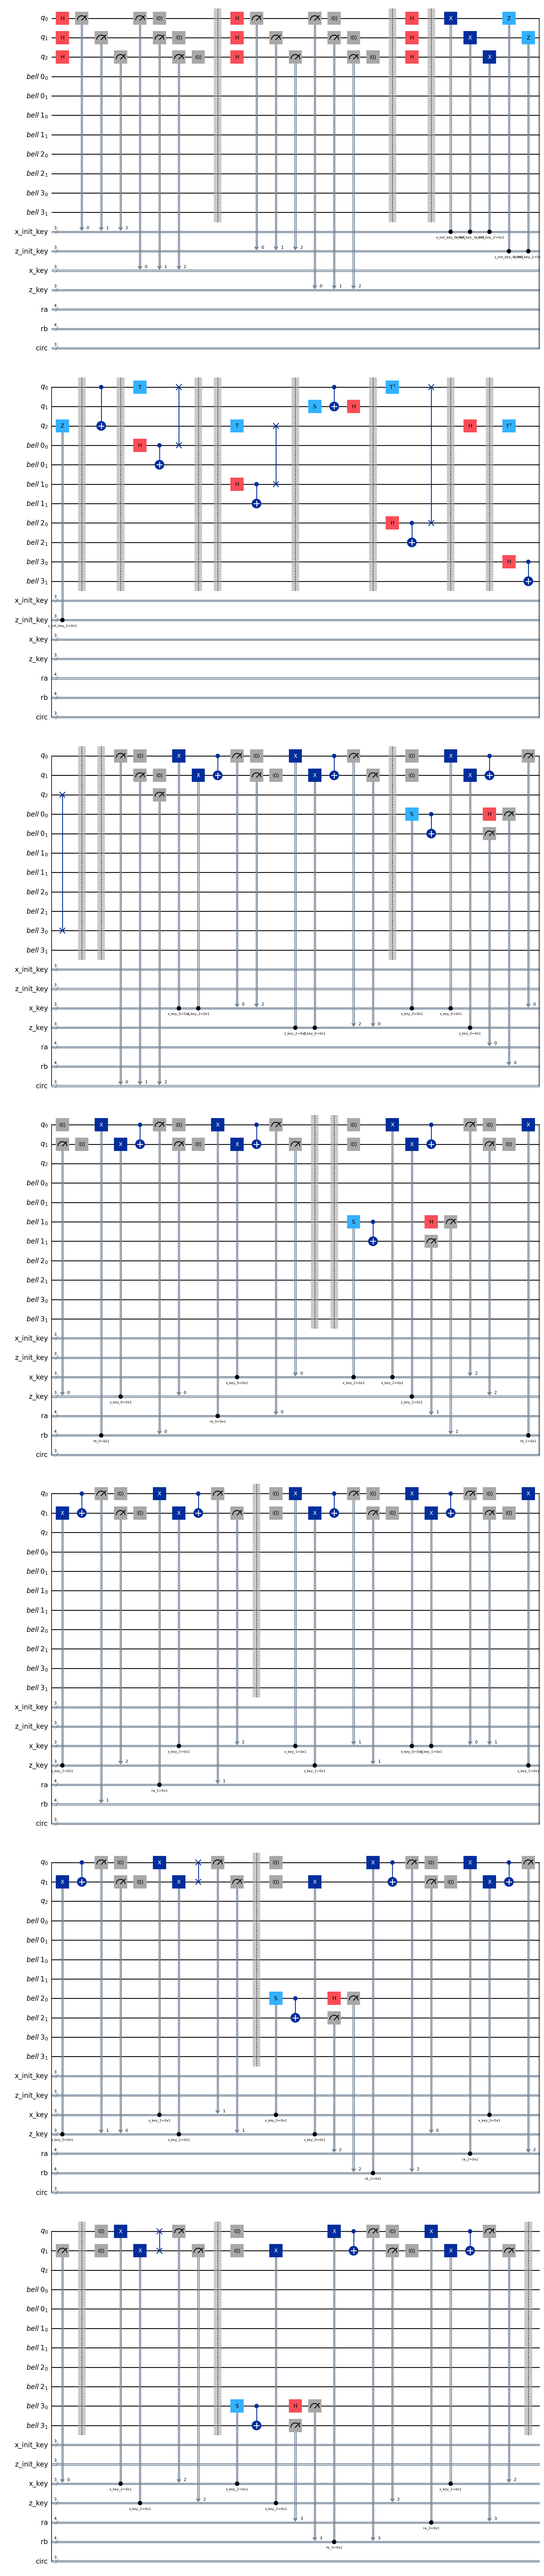

In [38]:
homomorphic_circuit.draw('mpl')

<a name='4'></a>
## 4 - Function ``create_simplified_homomorphic_circuit``

Args:
- init_circuit: Initial circuit by the client.
- main_circuit: Main circuit by the server. It must be compiled into Clifford+T gates.
- measured_qubits: Qubits that are measured to obtain the final result.

Returns:
- homomorphic_circuit: Simplified homomorphic circuit for the simulation.

The simulation of the homomorphic circuit is costly since it requires two qubits for each of the $T/T^\dagger$ gates. In a real scenary this has to be this way. However, for simulation purposes, we can simplify the circuit. We can perform the key updating of the client in parallel with the quantum gates of the server. Thus, we can measure the Bell register, reset it and reuse it for the Bell pair of the following $T/T^\dagger$ gate. This method is explained in the supplementary material of [[1]](https://iopscience.iop.org/article/10.1088/2632-072X/add3aa).

The instantiation of the circuit is the same as before, but in this case there is only a single Bell register with two qubits.

In [39]:
# Obtain the quantum registers of the main circuit.
registers = []
for index in range(len(main_circuit.qubits)):
    r = main_circuit.find_bit(main_circuit.qubits[index]).registers[0][0]
    if r not in registers:
        registers.append(r)

# Instantiate the homomorphic circuit with the quantum registers.
homomorphic_circuit = QuantumCircuit()
for index in range(len(registers)):
    homomorphic_circuit.add_register(registers[index])

# Obtain the qubits of the main circuit.
main_qubits = main_circuit.qubits

# Create classical registers for the keys.
x_init_key_reg = ClassicalRegister(len(main_qubits),'x_init_key')
z_init_key_reg = ClassicalRegister(len(main_qubits),'z_init_key')
homomorphic_circuit.add_register(x_init_key_reg)
homomorphic_circuit.add_register(z_init_key_reg)
x_key_reg = ClassicalRegister(len(main_qubits),'x_key')
z_key_reg = ClassicalRegister(len(main_qubits),'z_key')
homomorphic_circuit.add_register(x_key_reg)
homomorphic_circuit.add_register(z_key_reg)

# Create a quantum register for the Bell pairs.
bell_reg = QuantumRegister(2,'bell')
homomorphic_circuit.add_register(bell_reg)

# Create classical registers for the Bell measurements.
number_t_gates = count_gates(main_circuit,['t','tdg'])
ra_reg = ClassicalRegister(number_t_gates,'ra')
rb_reg = ClassicalRegister(number_t_gates,'rb')
homomorphic_circuit.add_register(ra_reg)
homomorphic_circuit.add_register(rb_reg)

# Create a quantum register for the classical gates.
# We use the same as the Bell pairs registers.
cl_gates_reg = bell_reg

# Obtain the classical registers of the original circuit (for semiclassical algorithms).
classical_registers = []
for index in range(len(main_circuit.clbits)):
    r = main_circuit.find_bit(main_circuit.clbits[index]).registers[0][0]
    if r not in classical_registers:
        classical_registers.append(r)
for index in range(len(classical_registers)):
    homomorphic_circuit.add_register(classical_registers[index])

# Create a classical register for measuring the main qubits.
measured_reg = ClassicalRegister(len(measured_qubits),'circ')
homomorphic_circuit.add_register(measured_reg)

The initialization by the client is also the same.

In [40]:
# Initialize the keys at random to the corresponding classical registers.
homomorphic_circuit.h(main_qubits)
homomorphic_circuit.measure(main_qubits,x_init_key_reg)
homomorphic_circuit.measure(main_qubits,x_key_reg)
homomorphic_circuit.reset(main_qubits)
homomorphic_circuit.barrier()
homomorphic_circuit.h(main_qubits)
homomorphic_circuit.measure(main_qubits,z_init_key_reg)
homomorphic_circuit.measure(main_qubits,z_key_reg)
homomorphic_circuit.reset(main_qubits)
homomorphic_circuit.barrier()

# Copy the initial circuit by the client.
for d in init_circuit.data:
    homomorphic_circuit.data.append(d)
homomorphic_circuit.barrier()

# Encrypt the circuit.
for index, q in enumerate(main_qubits):
    homomorphic_circuit.x(q).c_if(x_init_key_reg[index],1)
    homomorphic_circuit.z(q).c_if(z_init_key_reg[index],1)
homomorphic_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2), Qubit(QuantumRegister(2, 'bell'), 0), Qubit(QuantumRegister(2, 'bell'), 1)), clbits=())

In contrast to the previous simulation, now we apply the quantum gates of the server and the key updating rules with classical and quantum gates at the same time.

In [41]:
# Copy the main circuit by the server with the homomorphic updating rules.

# Create a dictionary relating each qubit to its index.
qubits_dict = {q:index for index, q in enumerate(main_qubits)}

t_count = 0
for d in main_circuit.data:
    name = d[0].name
    # Obtain the bits and qubits of the gate.
    gate_qubits = d[1]
    gate_clbits = d[2]

    if name == 'x':
        homomorphic_circuit.x(gate_qubits)

    elif name == 'z':
        homomorphic_circuit.z(gate_qubits)

    elif name == 'h':
        homomorphic_circuit.h(gate_qubits)
        classical_swap(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 's':
        homomorphic_circuit.s(gate_qubits)
        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 'sdg':
        homomorphic_circuit.sdg(gate_qubits)
        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 'cx':
        homomorphic_circuit.cx(gate_qubits[0],gate_qubits[1])
        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],x_key_reg[qubits_dict[gate_qubits[1]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,z_key_reg[qubits_dict[gate_qubits[1]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 't':
        homomorphic_circuit.barrier()
        homomorphic_circuit.t(gate_qubits)
        homomorphic_circuit.reset(bell_reg)
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.swap(gate_qubits[0],bell_reg[0])
        homomorphic_circuit.s(bell_reg[0]).c_if(x_key_reg[qubits_dict[gate_qubits[0]]],1)
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.measure(bell_reg,[rb_reg[t_count],ra_reg[t_count]])

        classical_cnot(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,rb_reg[t_count],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,ra_reg[t_count],x_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

        t_count += 1
        homomorphic_circuit.barrier()

    elif name == 'tdg':
        homomorphic_circuit.barrier()
        homomorphic_circuit.tdg(gate_qubits)
        homomorphic_circuit.reset(bell_reg)
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.swap(gate_qubits[0],bell_reg[0])
        homomorphic_circuit.s(bell_reg[0]).c_if(x_key_reg[qubits_dict[gate_qubits[0]]],1)
        homomorphic_circuit.cx(bell_reg[0],bell_reg[1])
        homomorphic_circuit.h(bell_reg[0])
        homomorphic_circuit.measure(bell_reg,[rb_reg[t_count],ra_reg[t_count]])

        classical_cnot(homomorphic_circuit,rb_reg[t_count],z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_cnot(homomorphic_circuit,ra_reg[t_count],x_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

        t_count += 1
        homomorphic_circuit.barrier()

    elif name == 'barrier':
        homomorphic_circuit.barrier(gate_qubits)

    elif name == 'measure':
        homomorphic_circuit.measure(gate_qubits,gate_clbits)
        classical_reset(homomorphic_circuit,z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    elif name == 'reset':
        homomorphic_circuit.reset(gate_qubits)
        classical_reset(homomorphic_circuit,x_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)
        classical_reset(homomorphic_circuit,z_key_reg[qubits_dict[gate_qubits[0]]],cl_gates_reg)

    else:
        raise Exception(f'Wrong gate in the circuit: {name}')

Finally, we measure the main qubits of the circuit.

In [42]:
# Measure the qubits of the original circuit.
homomorphic_circuit.barrier()
homomorphic_circuit.measure(measured_qubits,measured_reg)

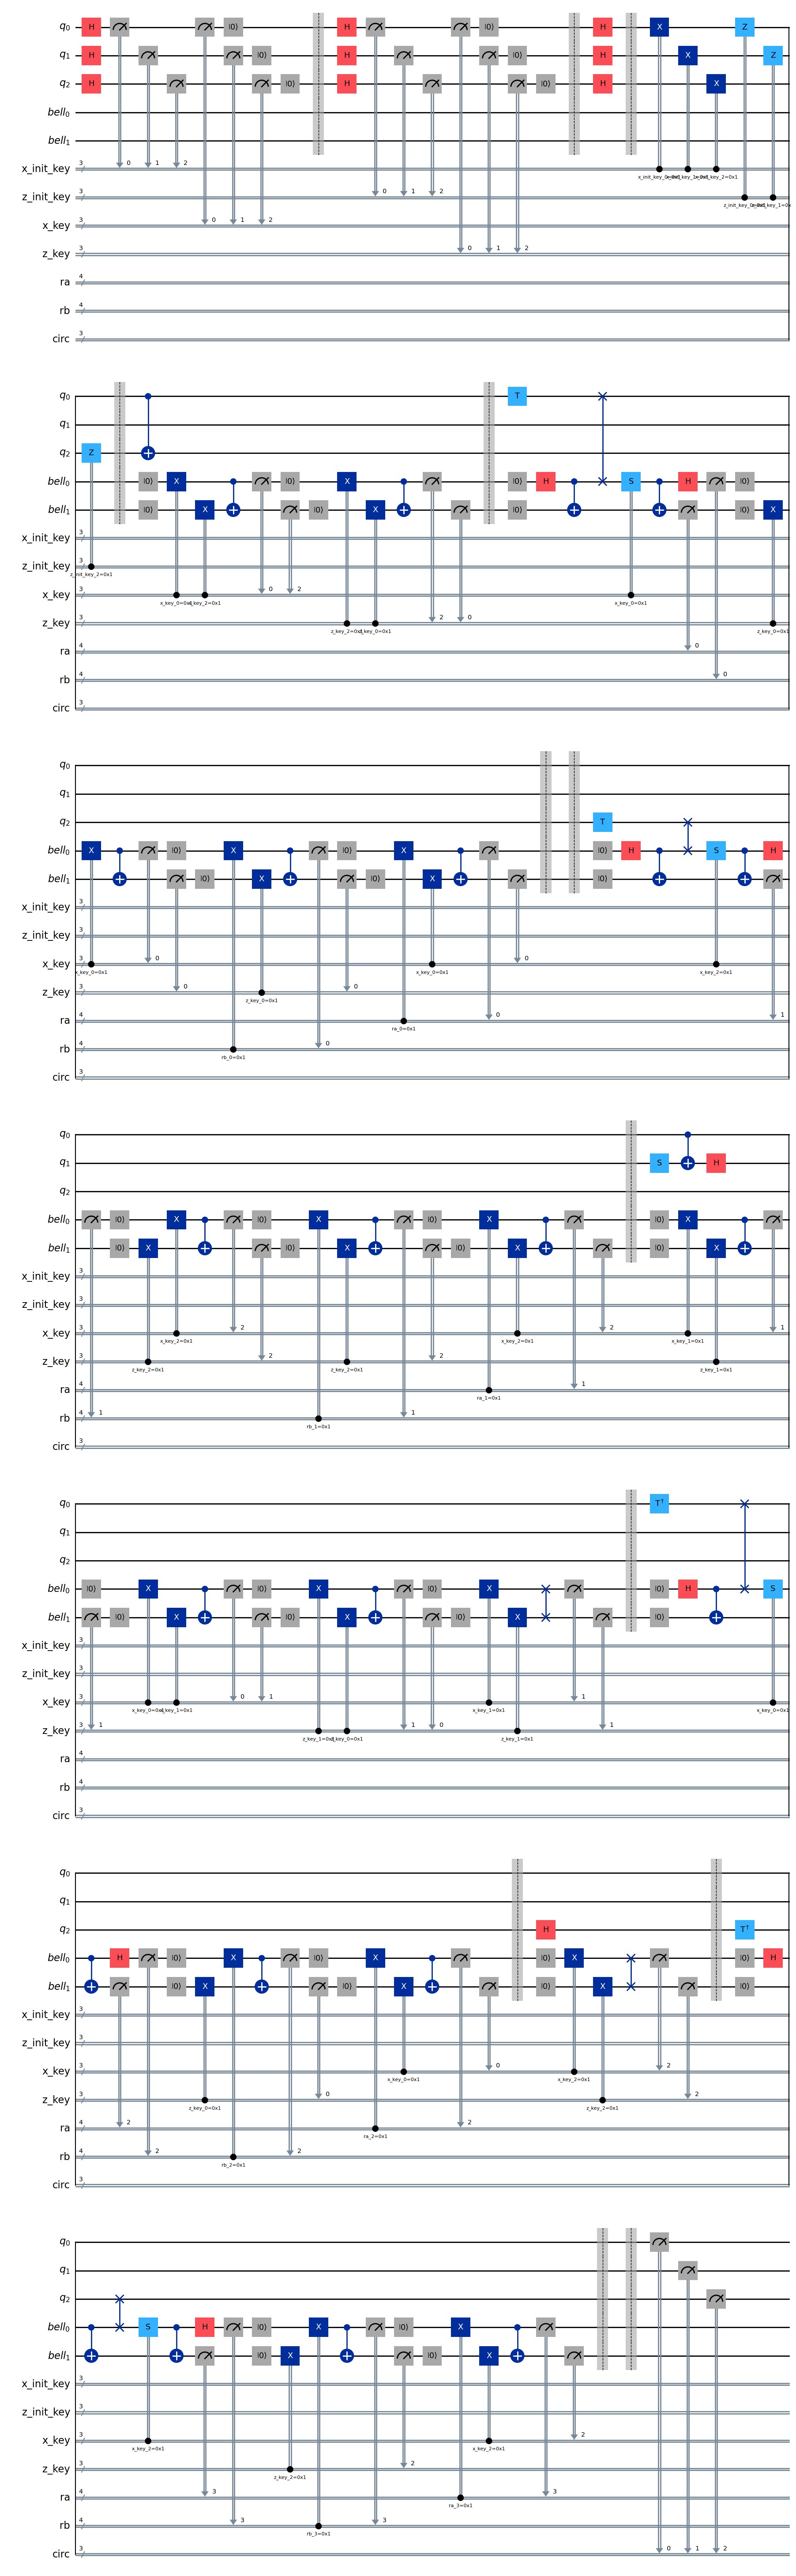

In [43]:
homomorphic_circuit.draw('mpl')

<a name='5'></a>
## 5 - Function ``last_register_counts``

Args:
- counts: Dictionary with the counts of the simulation.

Returns:
- last_counts: Dictionary with the counts of the last register.

The bitstring that we obtain from the homomorphic circuit corresponds to several classical register. However, we are only interested in the last one, which corresponds to the main qubits of the circuit.

In [44]:
counts = cqc.run_circuit(homomorphic_circuit,shots=10)
counts

{'100 100 000 001 1100 0101 110': 1,
 '010 010 000 100 1010 1000 110': 1,
 '100 100 101 001 1110 1011 011': 1,
 '110 001 111 010 1111 0010 001': 1,
 '011 101 010 000 1111 1100 100': 1,
 '000 000 001 111 1111 0010 101': 1,
 '101 001 000 110 0110 1101 000': 1,
 '101 100 000 010 0110 1011 100': 1,
 '011 010 001 001 1010 1010 111': 1,
 '111 001 110 101 0001 1011 010': 1}

We iterate the counts, taking only the bitstring of the last register, and adding the results.

In [45]:
last_counts = {}
for key in counts:
    last_key = key.split()[-1]
    if last_counts.get(last_key) is None:
        last_counts[last_key] = counts[key]
    else:
        last_counts[last_key] += counts[key]

In [46]:
last_counts

{'110': 2,
 '011': 1,
 '001': 1,
 '100': 2,
 '101': 1,
 '000': 1,
 '111': 1,
 '010': 1}

<a name='6'></a>
## 6 - Function ``decrypt_counts``

Args:
- counts: Encrypted counts.
- measured_positions: Positions in the circuit of the qubits being measured.

Returns:
- decrypted_counts: Decrypted counts.

The first register of the obtained bitstring corresponds to the final key for the $X$ gates. This functions takes this final key and apply it to the measured qubits of the main circuit. We need to provide the positions of the measured qubits in the circuit.

In [47]:
measured_positions = [0,1,2]

In [48]:
decrypted_counts = {}
for chain in counts:
    f_value = chain.split(' ')[-1]
    f_key = chain.split(' ')[2]
    f_value = [int(number) for number in f_value]
    f_key = [int(f_key[index]) for index in measured_positions]
    decrypted_chain = ''.join([str(f_key[index]^f_value[index]) for index in range(len(f_value))])
    if decrypted_counts.get(decrypted_chain) is None:
        decrypted_counts[decrypted_chain] = counts[chain]
    else:
        decrypted_counts[decrypted_chain] += counts[chain]

In [49]:
decrypted_counts

{'110': 6, '100': 3, '000': 1}

<a name='7'></a>
## 7 - Function counts_to_probability_distribution

Args:
- counts: Dictionary with the counts of the simulation.

Returns:
- probability_distribution: Numpy array with the probability distribution.

This function takes a dictionary with the counts of the simulation and transforms it into a probability distribution vector.

In [50]:
counts = decrypted_counts

In [51]:
# Take the number of elements in the computational basis.
N = 2**(len(list(counts.keys())[0]))

# Transform the counts into a probability distribution vector.
probability_distribution = np.zeros(N)
for bitstring in counts:
    probability_distribution[int(bitstring,2)] = counts[bitstring]
probability_distribution = probability_distribution / sum(probability_distribution)

In [52]:
probability_distribution

array([0.1, 0. , 0. , 0. , 0.3, 0. , 0.6, 0. ])

<a name='8'></a>
## 8 - References

- [1] **[S. A. Ortega, P. Fernández and M. A. Martin-Delgado. Implementing Semiclassical Szegedy Walks in Classical-Quantum Circuits for Homomorphic Encryption. Journal of Physics: Complexity, 6:025010, 2025.](https://iopscience.iop.org/article/10.1088/2632-072X/add3aa)**

- [2] **[N. J. Ross and P. Selinger. Optimal ancilla-free Clifford+T approximation of z-rotations. Quantum Information and Computation, 16:901–953, 2016.](https://dl.acm.org/doi/abs/10.5555/3179330.3179331)**